In [1]:
import numpy as np
import tensorflow as tf
import gym
from ppo import PPO
from recorder import Recorder
from logRewards import DataLogger
import warnings
warnings.filterwarnings('ignore') #ignora warnings
seed=42

2025-01-11 11:16:31.604607: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736590591.737395    4480 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736590591.775615    4480 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-11 11:16:32.075908: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

tf.random.set_seed(seed)
np.random.seed(seed)


# Configurazione ed esecuzione
#Lista di giochi a disposizione di Procgen:
""" 
    bigfish, bossfight, caveflyer, chaser, climber
    coinrun, dodgeball, fruitbot, heist, jumper
    leaper, maze, miner, ninja, plumber, starpilot
"""
seed=42
gameName="starpilot" 
env = gym.make('procgen:procgen-'+gameName+'-v0',distribution_mode='easy',start_level=seed,rand_seed=seed, num_levels=100, use_backgrounds=False)
recorder=Recorder(gameName)
dataLogger=DataLogger(gameName)
ppo=PPO(env,weightsPath=None,recorder=recorder,dataLogger=dataLogger,gameName=gameName)

I0000 00:00:1736590597.821757    4480 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2784 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


ACTOR CRITIC LOADED


Model: "actor_ppo"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128)            │        44,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ actor_ppo_dense4 (Dense)        │ (1, 15)                │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,095 (539.44 KB)

 Trainable params: 46,031 (179.81 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 92,064 (359.63 KB)

Model: "critic_ppo"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 128)            │        44,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ critic_ppo_dense4 (Dense)       │ (1, 1)                 │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,677 (518.27 KB)

 Trainable params: 44,225 (172.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 88,452 (345.52 KB)

In [ ]:


for epoch in range(ppo.nEpochs):                                            # Main training loop for n epochs

        obs ,actions ,logp , returns, advs = ppo.rollout()                                  # Get Rollout and infos
        #Check if batches contains nan or inf values
        try:
                tf.debugging.check_numerics(tf.cast(obs, tf.float32), "obs_batch has nan or inf values")
                tf.debugging.check_numerics(tf.cast(actions, tf.float32), "actions_batch has nan or inf values")
                tf.debugging.check_numerics(logp, "logp_t_batch has nan or inf values")
                tf.debugging.check_numerics(advs, "advs_batch has nan or inf values")
                tf.debugging.check_numerics(returns, "returns_batch has nan or inf values")
        except:
                print("OBS:")
                print(obs)
                print("logp BATCH HAS NAN OR INF VALUES")
                print(logp)
                print("ADVS BATCH HAS NAN OR INF VALUES")
                print(advs)
                print("returns BATCH HAS NAN OR INF VALUES")
                print(returns)
                break
                
        print(f"Epoch: {epoch} | Rollout completed")                     # Print loss for each epoch
        print(obs.shape,actions.shape,logp.shape,returns.shape,advs.shape)
        total_loss = ppo.train(obs,actions,advs,returns,logp)                                         # Push rollout in ppo and update policy accordingly
        print(f"Epoch: {epoch} | Loss: {total_loss}")                     # Print loss for each epoch
        ppo.save_model(epoch=epoch)
        ppo.update_hyperparams(epoch=epoch)
        if epoch % 5 ==0:
                ppo.evaluate_model()
        del obs ,actions ,logp , returns, advs
        


I0000 00:00:1736590599.029308    4480 cuda_dnn.cc:529] Loaded cuDNN version 90300


Reward rollout:  120.0
Epoch: 0 | Rollout completed
(4096, 64, 64, 3) (4096,) (4096,) (4096,) (4096,)
Total loss:  0.23876259  Policy loss:  0.010055581  Value loss:  0.27191544  Entropy loss:  -0.04320842
Total loss:  0.38402972  Policy loss:  0.36146238  Value loss:  0.070048325  Entropy loss:  -0.047480997
Total loss:  0.29841045  Policy loss:  0.15115273  Value loss:  0.19225895  Entropy loss:  -0.045001242
Total loss:  0.044923116  Policy loss:  -0.31054565  Value loss:  0.40284193  Entropy loss:  -0.047373157
Total loss:  -0.015457515  Policy loss:  -0.2776327  Value loss:  0.3092817  Entropy loss:  -0.04710651
Total loss:  0.3326792  Policy loss:  0.22298582  Value loss:  0.15629001  Entropy loss:  -0.046596613
Total loss:  0.10983881  Policy loss:  -0.20110138  Value loss:  0.35514358  Entropy loss:  -0.044203382
Total loss:  0.15579529  Policy loss:  -0.11609902  Value loss:  0.32013687  Entropy loss:  -0.048242558
Total loss:  0.14259851  Policy loss:  -0.04689529  Value loss

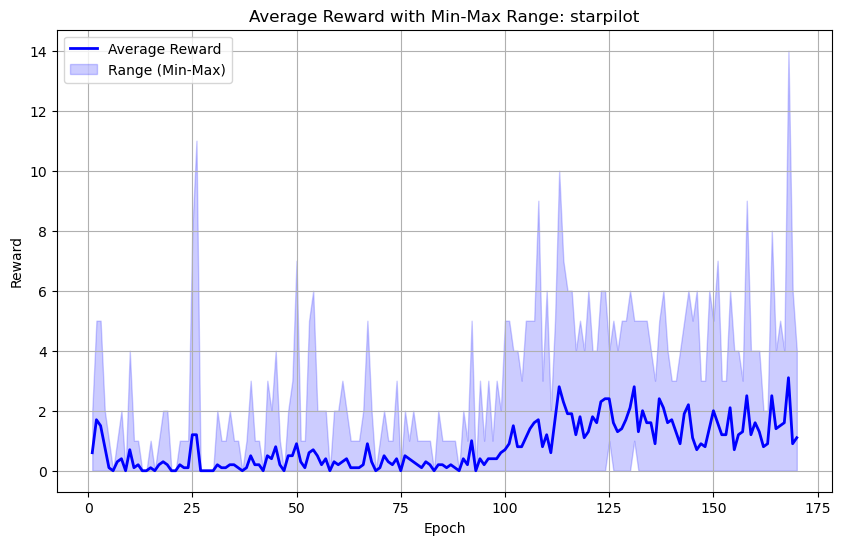

In [20]:
#Show graphs

dataLogger.showGraphAverageReward()

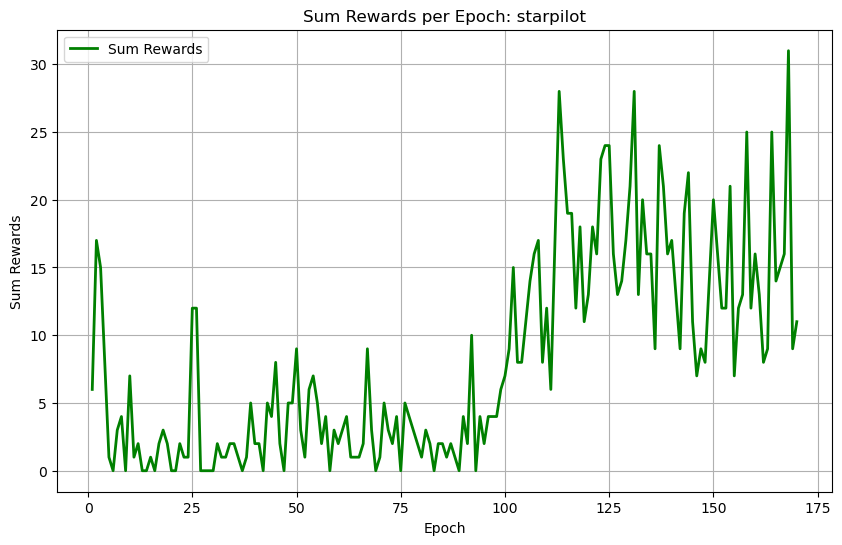

In [21]:

dataLogger.showGraphCumulativeReward()

In [22]:

seed=1
tf.random.set_seed(seed)
np.random.seed(seed)
env = gym.make('procgen:procgen-'+gameName+'-v0',distribution_mode='easy',start_level=seed,rand_seed=seed, num_levels=100, use_backgrounds=False)
ppo_weighted=PPO(env,weightsPath=None,recorder=None,dataLogger=None,gameName=gameName,training=False)

weighted_result=ppo_weighted.evaluate_model(100)
del ppo_weighted


ACTOR CRITIC LOADED


Model: "actor_ppo"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_14 (Sequential)      │ (None, 128)            │        44,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ actor_ppo_dense4 (Dense)        │ (1, 15)                │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,095 (539.44 KB)

 Trainable params: 46,031 (179.81 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 92,064 (359.63 KB)

Model: "critic_ppo"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_15 (Sequential)      │ (None, 128)            │        44,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ critic_ppo_dense4 (Dense)       │ (1, 1)                 │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,677 (518.27 KB)

 Trainable params: 44,225 (172.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 88,452 (345.52 KB)

Episode reward: 0.0
Episode reward: 1.0
Episode reward: 1.0
Episode reward: 2.0
Episode reward: 0.0
Episode reward: 0.0
Episode reward: 0.0
Episode reward: 1.0
Episode reward: 6.0
Episode reward: 0.0
Episode reward: 1.0
Episode reward: 0.0
Episode reward: 1.0
Episode reward: 0.0
Episode reward: 2.0
Episode reward: 0.0
Episode reward: 5.0
Episode reward: 4.0
Episode reward: 14.0
Episode reward: 0.0
Episode reward: 0.0
Episode reward: 1.0
Episode reward: 1.0
Episode reward: 1.0
Episode reward: 1.0
Episode reward: 0.0
Episode reward: 0.0
Episode reward: 6.0
Episode reward: 2.0
Episode reward: 0.0
Episode reward: 14.0
Episode reward: 2.0
Episode reward: 2.0
Episode reward: 1.0
Episode reward: 1.0
Episode reward: 0.0
Episode reward: 6.0
Episode reward: 0.0
Episode reward: 0.0
Episode reward: 1.0
Episode reward: 1.0
Episode reward: 2.0
Episode reward: 1.0
Episode reward: 0.0
Episode reward: 1.0
Episode reward: 6.0
Episode reward: 0.0
Episode reward: 0.0
Episode reward: 0.0
Episode reward: 1.

In [23]:
ppo_not_weighted=PPO(env,weightsPath="..",recorder=None,dataLogger=None,gameName=gameName,training=False)

result=ppo_not_weighted.evaluate_model(100,False)




--------- EXCEPTION :
File not found: filepath=../actor.keras. Please ensure the file is an accessible `.keras` zip file.
Errore nel caricamento dei pesi


Model: "actor_ppo"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_16 (Sequential)      │ (None, 128)            │        44,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ actor_ppo_dense4 (Dense)        │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,096 (172.25 KB)

 Trainable params: 44,096 (172.25 KB)

 Non-trainable params: 0 (0.00 B)

Model: "critic_ppo"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_17 (Sequential)      │ (None, 128)            │        44,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ critic_ppo_dense4 (Dense)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,096 (172.25 KB)

 Trainable params: 44,096 (172.25 KB)

 Non-trainable params: 0 (0.00 B)

Episode reward: 0.0
Episode reward: 0.0
Episode reward: 1.0
Episode reward: 2.0
Episode reward: 2.0
Episode reward: 4.0
Episode reward: 0.0
Episode reward: 0.0
Episode reward: 4.0
Episode reward: 0.0
Episode reward: 1.0
Episode reward: 0.0
Episode reward: 0.0
Episode reward: 5.0
Episode reward: 0.0
Episode reward: 0.0
Episode reward: 0.0
Episode reward: 0.0
Episode reward: 0.0
Episode reward: 0.0
Episode reward: 2.0
Episode reward: 1.0
Episode reward: 2.0
Episode reward: 2.0
Episode reward: 3.0
Episode reward: 3.0
Episode reward: 2.0
Episode reward: 0.0
Episode reward: 0.0
Episode reward: 2.0
Episode reward: 0.0
Episode reward: 1.0
Episode reward: 0.0
Episode reward: 0.0
Episode reward: 0.0
Episode reward: 1.0
Episode reward: 0.0
Episode reward: 0.0
Episode reward: 0.0
Episode reward: 2.0
Episode reward: 3.0
Episode reward: 1.0
Episode reward: 4.0
Episode reward: 2.0
Episode reward: 4.0
Episode reward: 7.0
Episode reward: 1.0
Episode reward: 0.0
Episode reward: 0.0
Episode reward: 0.0


In [24]:
print("Weighted model result: ",weighted_result)
print("Not weighted model result: ",result)

Weighted model result:  (2.0, 0.0, 14.0, 200.0)
Not weighted model result:  (1.51, 0.0, 7.0, 151.0)
